# Critical Minerals Mapping Bounty 

As global demand for critical raw materials is set to increase significantly due to population growth and changes in global consumption patterns, identifying critical mineral deposits efficiently has become increasingly important.

To this end, we aim to explore the use of public geoscience datasets for mapping critical mineral deposits in specific regions, along with additional data that might highlight conditions conducive to their presence and formation. This effort is designed as a foundation for mineral prospectivity analysis, which utilizes geological, geochemical, and geophysical data in maps or 'evidence layers.'

For this initiative, we invite you to find and use geological, geochemical, magnetic, and any other publicly available spatial data that, in your opinion, could be essential for the mapping of critical mineral deposits.

Your task involves gathering, transforming, analyzing data for selected areas of interest  and creating a dashboard to evaluate the impact of the collected geospatial data. 
In this bounty we suggest you focus on British Columbia, Nunavult, Ontario, Quebec, and Yukon provinces, all with the potentilly valuable presence of CMs. Additional provinces may be considered to contrast your ideas.  

We encourage the use of feature importance analysis, PCA analysis, or any other analytical methods you find fitting. Submissions that meet a specific set of formal criteria (see Rules for details) will qualify for rewards.

Submissions will be evaluated in the following categories, for which awards will be given:

- The best story  
- The best dashboard
- as well as 3 x honorable mentions


While traditional models based on regional geophysics have been used for this purpose, we are optimistic about the potential of machine learning models to improve the targeting in the exploration of critical raw materials.

We initially believe that the best mix of data may vary by region and type of deposit. Generally, the following data are considered necessary for such analysis:

- General: Names of entities/units
- Targets layer: Presence or absence of critical mineral (CM) deposits/occurrences.
- Geospatial coverage
- Geology, including rock types and ages (geochronology)
- Gravity features and anomalies
- Magnetic features and anomalies
- Geochemical features
- You could add any others features which could be reasonable to have, i.e. locations of active mines or historical mining activity, etc.


Therefore, the main goals are:
- **Create a dataset combination (based on publicly available datasets) for potential prospectivity modeling**.
- **Build a dashboard to analyze which factors indicate (or at least suggest some clues for) the desired targets (here, the presence/absence of CM Deposits)**.
- **Tell us a story that you found in looking through the data in your dashboard"

Below we provide a suggested pipeline to give you a structured start. Some of steps are only described (without code snippets for sake of continuity), please don't hesitate to reach out for additional hints or guidance to navigate any of the steps.


## 0. Import required libraries

In [1]:
!pip install panel plotly hvplot --quiet
!pip install --upgrade pyviz_comms #for JupytherLabs
!pip install geopandas rasterio geopy --quiet

In [2]:
# import basic libraries
import os
import zipfile
import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point

import matplotlib as mpl
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import tqdm

import rasterio

from rasterio.mask import mask

import warnings
warnings.filterwarnings("ignore")

## 1. Preliminary processing of dataset 

Preparing a robust dataset with geological data for a particular area of interest involves several preliminary actions to ensure accuracy and usability. Some of these essential steps include (but are not limited to):

 - Geocoding Data (Forward or Reverse): Assigning geographical coordinates to the data or converting/geocoding geographic coordinates into a readable location name, for instance, using the Nominatim service to map locations accurately.
 - Defining Area of Interest: Defining and extracting the dataset by the specific borders of your area of interest, ensuring that the data is relevant and manageable.
 - Resampling of Rasters: Adjusting the resolution of raster data (such as satellite imagery or maps) to align with the scale of analysis or to match other data layers.
 - Transforming CRS: Converting data between different Coordinate Reference Systems to ensure that all data aligns on a single, consistent basis for accurate analysis and comparison.
 - Data Cleaning and Normalization: Ensure your data is clean, consistent, and formatted correctly. This may involve removing duplicates, correcting errors, and standardizing data formats. 
 - Spatial Interpolation: If your geological data has missing values or you need to predict values for locations not directly sampled, spatial interpolation techniques can be used to estimate those values based on the spatial correlation of measured points.

To maintain conciseness and focus in our starter notebook, we have omitted these detailed preliminary actions. But if you require additional guidance on how to perform these actions, **please let us know through our feedback forum**.  

## 2. Download and plot layers
Let's assume that all preliminary actions were done, below we demonstrate some code to read and plot some layers with integrated dataset of precense CMs (as target points) for province Manitoba. 

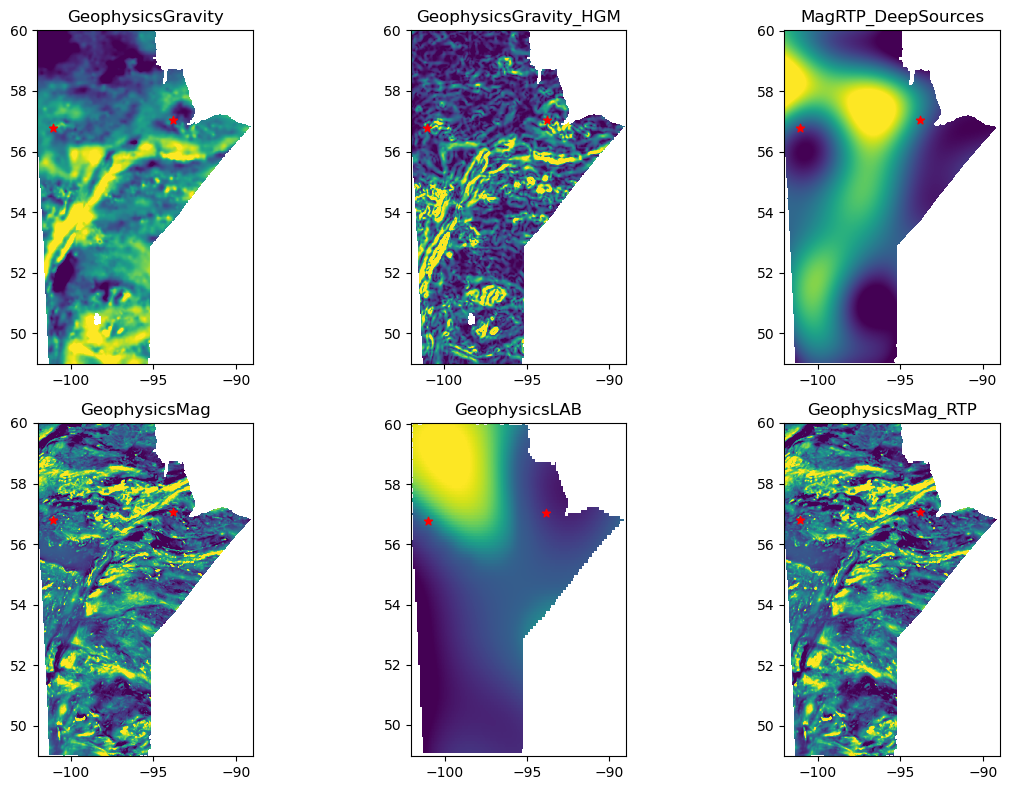

In [3]:
area_of_interest = 'Manitoba' 

path_to_AOI = f'{area_of_interest}'
all_files = os.listdir(path_to_AOI)
# Define the path for the new shapefile
output_shapefile_path = f'{path_to_AOI}/CM_presence_{area_of_interest}.shp'


tif_files = [file for file in all_files if file.endswith('_resampled.tif')]
n_cols = 3
n_rows = int(np.ceil(len(tif_files)/n_cols))


gdf = gpd.read_file(output_shapefile_path)


fig, axes = plt.subplots(n_rows, n_cols, figsize=(12,8))


for i, ax in enumerate(axes.flatten()):
    if i < len(tif_files):
        fn = tif_files[i]
        #print(fn)
        with rasterio.open(f'{path_to_AOI}/{fn}', 'r') as src:
            # read spatial information
            transform = src.transform
            region = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
            # read band 1 data
            d = src.read(1)
            nodata_mask = d == src.nodata
            d[nodata_mask] = np.nan

            #print(d.shape)
            ax.imshow(d, vmin=np.nanpercentile(d, 5), vmax=np.nanpercentile(d, 95), extent=region)
           
            #adjusting title for each layer
            title = os.path.splitext(os.path.basename(fn))[0]
            
            title = title.replace(f"_USCa_only_{area_of_interest}", "")
            title = title.replace(f"_only_{area_of_interest}", "")
            title = title.replace(f"USCanada", "")
            title = title.replace(f"_resampled", "")
            ax.set(title = title)
            gdf.plot(ax=ax, marker='*', facecolor='r')
    else:
        ax.axis('off')
        
plt.tight_layout()         
plt.show()


## 3. Preparing a Labeled Dataset 
Below, we offer essential code snippets to prepare a labeled dataset, which can serve as the foundation for identifying the most important features using various machine learning techniques such as Decision Trees, Random Forests, Gradient Boosting Machines (GBMs), etc. 


### 3.1. Preparing labels from target points and creating dataset with all layers

Number of NaN values in the array: 160539
Number of non-NaN values in the array, True(1): 1724,False(0): 276217


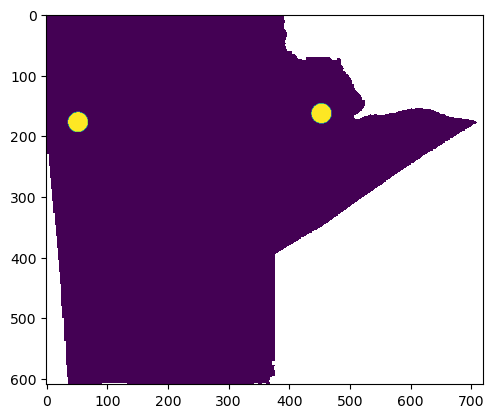

In [4]:
# import rasterize module
from rasterio.features import rasterize

# rasterize the target points with some buffer (choosen empirically)  
geometry_generator = ((geom, 1) for geom in gdf.buffer(0.3).geometry)
labels = rasterize(shapes=geometry_generator, out_shape=d.shape, fill=0, transform=transform).astype('float32')
labels[nodata_mask] = np.nan
plt.figsize=(10,10)
plt.imshow(labels)
print(f"Number of NaN values in the array: {np.sum(np.isnan(labels))}")
print(f"Number of non-NaN values in the array, True(1): {np.sum(labels==1)},False(0): {np.sum(labels==0)}")

### 3.2. Gathering together all layers 

In [5]:
def read_raster(raster_path):
    with rasterio.open(raster_path) as src:
        return src.read(1) 

# Reading the rasters
feature_arrays = [read_raster(f'{path_to_AOI}/{file}') for file in tif_files]
label_array = labels

# Flatten each array to convert 2D spatial data into a 1D array
feature_data = np.column_stack([feature_array.flatten() for feature_array in feature_arrays])
labels = label_array.flatten()

# Remove NaNs
valid_indexes = ~np.isnan(labels)
feature_data = feature_data[valid_indexes]
labels = labels[valid_indexes]

print(feature_data.shape, labels.shape)

# Creating feature names by simplify and clean up the filenames
feature_names = [
    file.replace('_USCa', '')
    .replace('USCanada', '')
    .replace(f'_only_{area_of_interest}_resampled.tif', '')
    .replace(path_to_AOI + '/', '')
    for file in tif_files
]

feature_names = [name.split('/')[-1] for name in feature_names]

df = pd.DataFrame(feature_data, columns=feature_names)
df['Labels'] = labels

#print(df)

filename = f'{path_to_AOI}/features_{area_of_interest}.csv'
df.to_csv(filename, index=False)

print(f"Data saved to {filename}")

(277941, 6) (277941,)
Data saved to Manitoba/features_Manitoba.csv


## 4. Feature engeneering: eliminate autocorrelation, create synthetics feature, etc. ..

Feature engineering offers an exceptional opportunity to enhance datasets and uncover unexpected insights, particularly in complex fields like geological analysis. Predictions may be possible utilizing raw or processed data, and as such feature generation may be ***optional*** but exploration of this type of predictive feature set is highly recommended:

 - Elimination of Correlated Features & Dimensionality Reduction: This step aims to reduce feature redundancy, sharpen the focus on the most informative geological indicators, reduce complexity, and enhance computational efficiency.

 - Spatial Aggregation: By summarizing spatial data into meaningful units, such as grid cells, this approach generates new, higher-level information and highlights areas with significant potential for performing a specific task.

 - Creating Domain-Specific Features: Enhancing key features by blending with synthetic ones may help to uncover geological insights — ratios, presence of anomalies, difference between two features, or deviations from standard values (e.g., unusual rock formations, soil compositions, or geochemical signatures) may help to further refine the dataset.

## 5.Using Statistical and Machine Learning techniques to Identify Key Features for further Prospectivity Mapping

Applying statistical and/or machine learning techniques such as Correlation(Causation?) Analysis,  Decision Trees, Random Forests, Gradient Boosting Machines (GBMs), etc to identify key predictive features (including synthetic, if applicable). 

In [6]:
# Correlation analysis between all features and targets

# Compute correlation with labels
correlation_with_labels = df.corr()['Labels'].drop('Labels')

# Convert correlation_with_labels to a numpy array for easy indexing
correlation_array = correlation_with_labels.values


# Feature Importance Analysis of features
from sklearn.ensemble import RandomForestClassifier

# Update list of feature_names
feature_names = df.drop('Labels', axis = 1).columns
feature_data = df[feature_names]

# Train Random Forest Classifier for Feature Importance
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(feature_data, labels)

# Get feature importances
feature_importances = clf.feature_importances_

# Sort features by feature importance for consistent ordering
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Sort the correlation and importance arrays according to the sorted indices
sorted_correlation = correlation_array[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Combine the data into a DataFrame
df_analysis = pd.DataFrame({
    'Feature Names': feature_names,
    'Sorted Importances': sorted_importances,
    'Sorted Correlation': sorted_correlation
})

# Construct the filename and save the DataFrame to a CSV file
filename = f'{path_to_AOI}/FA_{area_of_interest}.csv'
df_analysis.to_csv(filename, index=False)

print(f"Data saved to {filename}")

Data saved to Manitoba/FA_Manitoba.csv


## 6. Build Dashboard to Demonstrate Correlation of Different Factors with Targets (Presence/Absence of CM Deposits)
The Panel library is a potenitially useful resource to illustrate the influence of features or feature groups on the CM prospectivity of the AOI. The example dashboard below is only illustrative of the approach and should not be taken as a directive. The data behind plots below are randomly generated and could not be used in real analysis. 

Dashboards should run in a Jupyter Notebook, or should leverage easily implemented open source solutions.

Column
    [0] Markdown(str)
    [1] Matplotlib(Figure, tight=True)
    [2] Markdown(str)
    [3] Matplotlib(Figure, tight=True)
    [4] Markdown(str)
    [5] Row
        [0] Markdown(str)
        [1] Select(options=['Quebec', 'British Columb...], value='Quebec')
        [2] ParamFunction(function, _pane=Markdown, defer_load=False)
    [6] Row
        [0] ParamFunction(function, _pane=Matplotlib, defer_load=False)
        [1] ParamFunction(function, _pane=Matplotlib, defer_load=False)
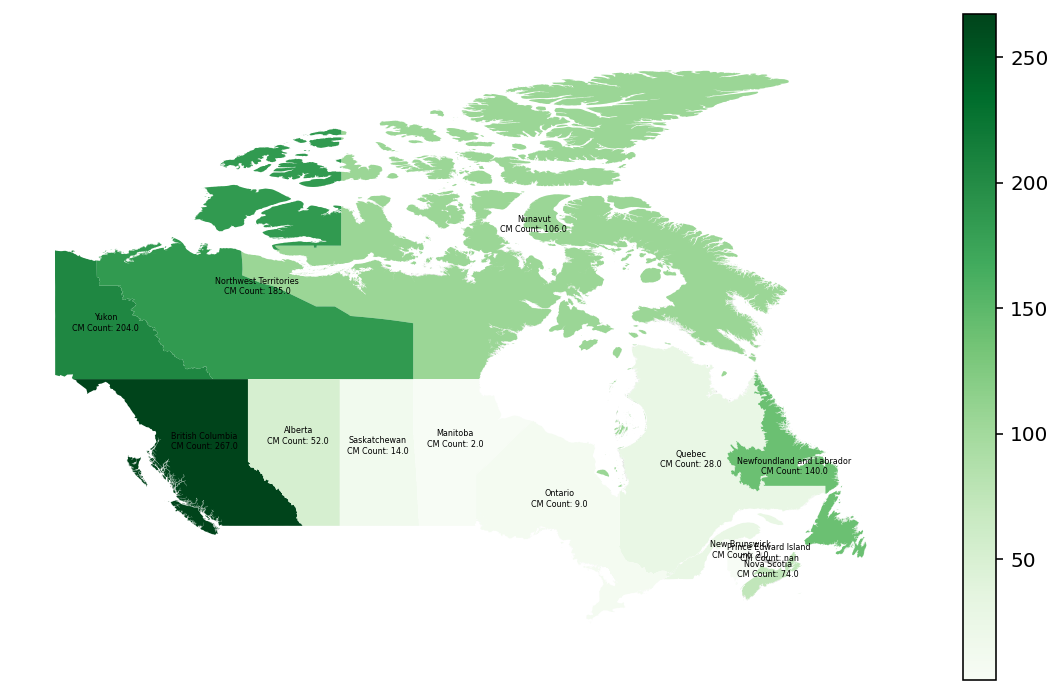
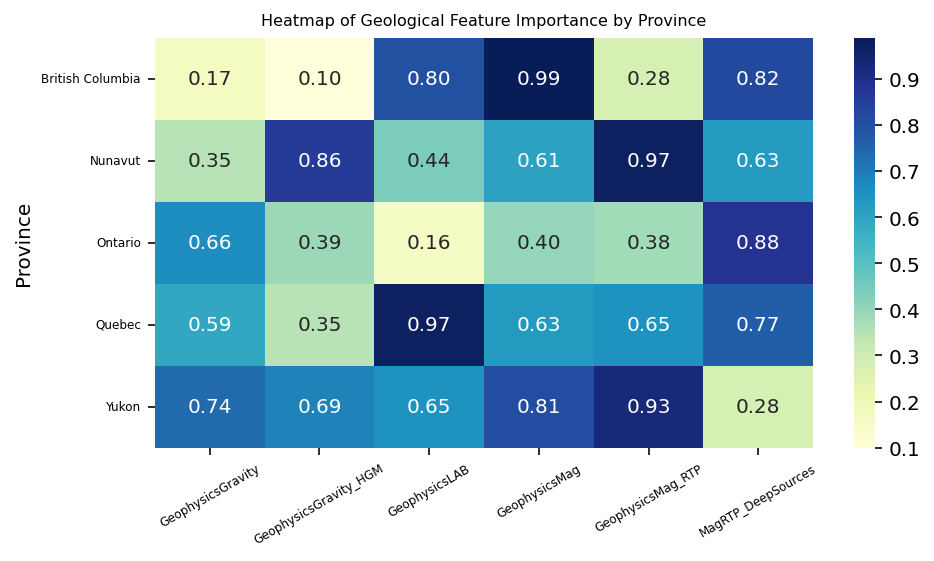
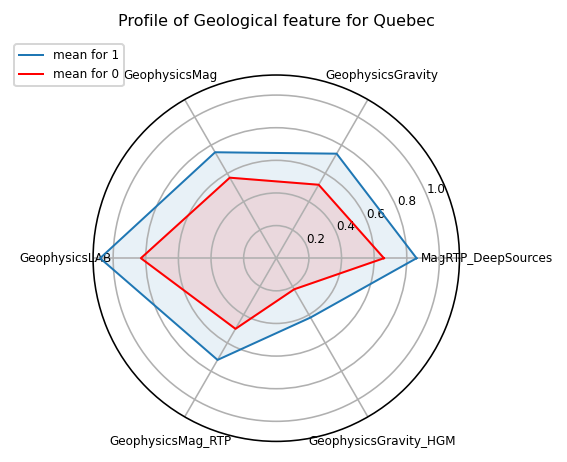
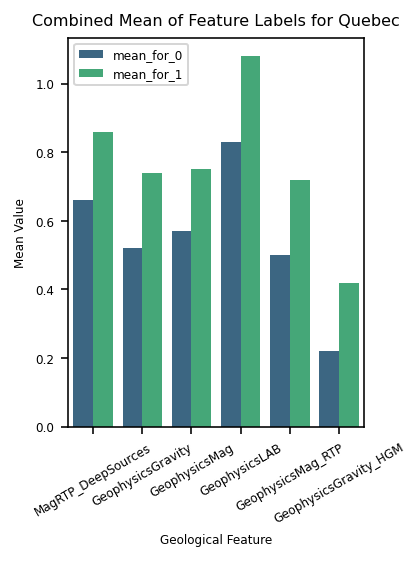

In [7]:
import panel as pn
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from math import pi

pn.extension()

df_url = 'feature_synthetic.csv'
df_updated = pd.read_csv(df_url)
# Create the AOI selector widget
AOI_selector = pn.widgets.Select(options=list(df_updated['Province'].unique()))


import geopandas as gpd

def plot_canada_provinces_map():
    # Load the shapefile for Canada's provinces
    file_CMs = 'CM_presence_Canada.shp'
    CMs = gpd.read_file(f'./map_Canada/{file_CMs}')

    # Aggregate CM presence data by province
    CM_counts_by_province = CMs.groupby('province').size().reset_index(name='CM_count')
    CM_counts_by_province.columns = ['PRENAME', 'CM_count']
    
    
    
    file_boundaries = 'borders_only_Canada.shp'
    canada_provinces_shapefile = f'./map_Canada/{file_boundaries}'
    canada_map = gpd.read_file(canada_provinces_shapefile)
    

    #Merge the aggregated CM data with the provinces shapefile
    canada_with_CM = canada_map.merge(CM_counts_by_province, on='PRENAME', how='left')

    # Plotting
    fig = Figure(figsize=(10, 6))
    ax = fig.subplots()
    # Create the choropleth map, fill NaN values with 0 for provinces without CM data
    canada_with_CM.plot(column='CM_count', ax=ax, legend=True, cmap='Greens', missing_kwds={'color': 'lightgrey'})

    canada_with_CM.apply(lambda x: ax.annotate(text=f"{x['PRENAME']}\nCM Count: {x['CM_count']}", 
                                           xy=x.geometry.centroid.coords[0], 
                                           ha='center', 
                                           fontsize=4), axis=1)
    ax.axis('off')
    #ax.set_title('Choropleth Map of Canada\'s Provinces with CM Presence', size=10)

    return pn.pane.Matplotlib(fig, tight=True)


# Heatmap plot function

def heatmap_plot():
    heatmap_data = df_updated.pivot_table(index='Geological Feature', columns='Province', values='Importance Value').T  # Transpose the data
    fig = Figure(figsize=(7, 4))  # Adjust the figure size as needed
    ax = fig.subplots()
    sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f", ax=ax)
    ax.set_title('Heatmap of Geological Feature Importance by Province', size=8)
    ax.set_xlabel('',size = 6)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.tick_params(axis='both', which='minor', labelsize=4)
    ax.tick_params(axis='x', rotation=30)
    
    fig.tight_layout()
    return pn.pane.Matplotlib(fig, tight=True)


# Spider chart plot function
def spider_plot(AOI):
    
    fig = Figure(figsize=(4, 4)) 
    ax = fig.subplots(subplot_kw=dict(polar=True))
    province_data = df_updated[df_updated['Province'] == AOI]
    categories = province_data['Geological Feature'].values
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # mean_of_feature_label_1
    values1 = list(province_data['mean_for_1'].values.flatten()) + [province_data['mean_for_1'].values.flatten()[0]]
    ax.plot(angles, values1, linewidth=1, linestyle='solid', label='mean for 1')

    # mean_of_feature_label_0
    values0 = list(province_data['mean_for_0'].values.flatten()) + [province_data['mean_for_0'].values.flatten()[0]]
    ax.plot(angles, values0, linewidth=1, linestyle='solid', label='mean for 0', color='red')

    ax.fill(angles, values1, alpha=0.1)
    ax.fill(angles, values0, alpha=0.1, color='red')

    ax.set_thetagrids([a * 180 / pi for a in angles[:-1]], categories)
    ax.set_title(f'Profile of Geological feature for {AOI}', size=8, y=1.1)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.tick_params(axis='both', which='minor', labelsize=4)
    ax.legend(title='',loc='upper right', bbox_to_anchor=(0.1, 1.1), fontsize=6)
    fig.tight_layout()
    
    return pn.pane.Matplotlib(fig, tight=True)

def combined_barplot_feature_means(province):
    # Prepare data: stack label_0 and label_1 data
    province_data = df_updated[df_updated['Province'] == province]
    province_data_melted = province_data.melt(id_vars=['Geological Feature'], value_vars=['mean_for_0', 'mean_for_1'], 
                                               var_name='Label', value_name='Mean Value')
    fig = Figure(figsize=(3, 4)) 
    # Plot# Adjust the figure size as needed
    ax = fig.subplots()
    sns.barplot(data=province_data_melted, x='Geological Feature', y='Mean Value', hue='Label', ax=ax, palette='viridis')
    
    ax.set_title(f'Combined Mean of Feature Labels for {province}', size = 8)
    ax.set_ylabel('Mean Value', size = 6)
    ax.set_xlabel('Geological Feature',size = 6)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.tick_params(axis='both', which='minor', labelsize=4)
    ax.tick_params(axis='x', rotation=30)
    ax.legend(title='', fontsize=6, title_fontsize='10')
    fig.tight_layout()
    plt.close()
    
    return pn.pane.Matplotlib(fig, tight=True)


# Text display function for points with label==1
@pn.depends(AOI=AOI_selector.param.value)
def points_text(AOI):
    points = df_updated[df_updated['Province'] == AOI]['Amount of deposits'].iloc[0]
    return f"## The amount of target points (deposits + buffers) is: {points}"

# Creating the dashboard layout
title0 = """

<hr>

# Map Of Province of Canada graduated by Critical Minerals' (Pb-Zn) Presence"

<hr> 
 
 
""" 


title = """

<hr>

# Importance of Geophysical/Geomagnetic Features to Indicate of CM Presence"

<hr> 
 
 
""" 
heatmap = heatmap_plot()


title1 = """

<hr>

# Profiling Geophysical/Geomagnetic Features for chosen Province

<hr>

"""
combined_barplot = pn.bind(combined_barplot_feature_means, province=AOI_selector)

dashboard = pn.Column(
    title0,
    plot_canada_provinces_map(),
    title,
    heatmap,
    title1,
    pn.Row(f'## Select province: ', AOI_selector, points_text),
    pn.Row(pn.bind(spider_plot, AOI=AOI_selector), combined_barplot)
)


# Display the dashboard
dashboard.servable()
